In [11]:
options(warn=-1)
if (!require(Matrix)) install.packages('Matrix')
if (!require(glmnet)) install.packages('glmnet')
if (!require(mvtnorm)) install.packages('mvtnorm')
if (!require(factoextra)) install.packages('factoextra')
if (!require(plotly)) install.packages('plotly')
if (!require(reshape2)) install.packages('reshape2')
if (!require(dplyr)) install.packages('dplyr')
if (!require(svglite)) install.packages('svglite')
if (!require(ggforce)) install.packages('ggforce')
library(Matrix)
library(glmnet)
library(mvtnorm)
library(factoextra)
library(plotly)
library(reshape2)
library(htmlwidgets)
library(dplyr, warn.conflicts = FALSE)
options(dplyr.summarise.inform = FALSE)
library(svglite)
library(ggforce)

In [3]:
get_intercept_slope <- function(model) {
    return(summary(model)$coefficients[1:2,1])
}

generate_data <- function(s,d,m,eta,seed) {
  set.seed(seed)
  x_values <- rnorm(s,mean=0,sd=1)
  x_index <-  sample(1:d, s, replace = FALSE)
  x <- sparseVector(x_values, x_index, d)
  A <- matrix( rnorm(d*m,mean=0,sd=1), d, m)
  e <- matrix( rnorm(d*m,mean=0,sd=eta), 1, m)
  b <- rnorm(1,mean=0,sd=4)
  y <- x %*% A + b + e
    
  return(MatrixB <- cbind(t(A), t(y)))
    
  #return(list("x"=t(A),"y"=t(y)))

}

compute_summary <- function(data) {
    
    m <- nrow(data)
    d <- ncol(data)-1

    rmse_lasso_test <- vector("list", (m/2)-1)
    rmse_lasso_train <- vector("list", m/2-1)

    rmse_lm_test <- vector("list", m/2-1)
    rmse_lm_train <- vector("list", m/2-1)

    for (i in 2:(m/2)){
        

            df <- data.frame("id"=seq.int(nrow(data)))

            if (d==1 | i == 2) {
                df_temp <- data.frame("x"=data[,1],"y"=data[,2])
                model <- lm(formula = y~x,data=head(df_temp,i))
                df$p_lm <- predict(model, newdata = df_temp)
                df$p_lasso <- predict(model, newdata = df_temp)
                df$y <- data[,2]
            } else {
                cvfit <- cv.glmnet(data[1:i,1:d], data[1:i,d+1], alpha=1)
                fit_lasso <- glmnet(x=data[1:i,1:d], y=data[1:i,d+1], alpha=1,lambda=cvfit$lambda.min)
                df$p_lasso <- predict(fit_lasso,newx=data[,1:d])
                df$y <- data[,d+1]
                if(i>=d+1) {
                    fit_lm <- glmnet(x=data[1:i,1:d], y=data[1:i,d+1], lambda=0,alpha=1)
                    df$p_lm <- predict(fit_lm,newx=data[,1:d])
                } else {
                    df$p_lm <-0
                }
            }

            df <- df %>% 
                mutate (train_test = if_else(as.numeric(id) <= i, 'train', 'test', missing = NULL)) %>% 
                mutate(residuals_lm = (y-p_lm)*(y-p_lm),residuals_lasso = (y-p_lasso)*(y-p_lasso),count = 1) %>% 
                group_by(train_test) %>%
                summarize(RMSE_lm =sqrt(sum(residuals_lm)/sum(count)),RMSE_lasso =sqrt(sum(residuals_lasso)/sum(count)))
                rmse_lasso_test[[i-1]] <- df$RMSE_lasso[1]
                rmse_lasso_train[[i-1]] <- df$RMSE_lasso[2]
                rmse_lm_test[[i-1]] <- if_else(i>=d+1,df$RMSE_lm[1],NULL)
                rmse_lm_train[[i-1]] <- if_else(i>=d+1,df$RMSE_lm[2],NULL)
        
    }

    df1 <- data.frame("m"=seq(2,m/2),method='lasso',set='holdout',metric='rmse_lasso_test')
    df1$RMSE <- as.numeric(rmse_lasso_test)

    df2 <- data.frame("m"=seq(2,m/2),method='linear regression',set='holdout',metric='rmse_lm_test')
    df2$RMSE <- as.numeric(rmse_lm_test)

    df3 <- data.frame("m"=seq(2,m/2),method='lasso',set='train',metric='rmse_lasso_train')
    df3$RMSE <- as.numeric(rmse_lasso_train)

    df4 <- data.frame("m"=seq(2,m/2),method='linear regression',set='train',metric='rmse_lm_train')
    df4$RMSE <- as.numeric(rmse_lm_train)

    df_summary <- rbind(df1,df2,df3,df4)
    
    return(df_summary)
}

generate_surface <- function(data,model) {
    xs <- data[,1]
    ys <- data[,2]
    zs <- data[,3]


    axis_x <- c(min(xs), max(xs))
    axis_y <- c(min(ys), max(ys))
    lm_surface <- expand.grid(x = axis_x,y = axis_y,KEEP.OUT.ATTRS = F)
    lm_surface$z<- predict.lm(model, newdata = lm_surface)
    lm_surface <- acast(lm_surface, y ~ x, value.var = "z") #y ~ x

    return(list("x"=axis_x,"y"=axis_y,"z"=lm_surface))
    
}

In [4]:
s <- 1
d <- 1
b <- 2
m <- 30
sd <- 0.3
seed <- 131
data <- generate_data(s,d,m,sd,seed)
df <- data.frame("x"=data[,1],"y"=data[,2],"i"=seq.int(nrow(data)))
df <- df %>%  mutate (set = if_else(as.numeric(i) <= b, 'train', 'holdout', missing = NULL)) 
model <- lm(formula = y~x,data=head(df,b))
model_full <- lm(formula = y~x,data=df)
coefficients <- get_intercept_slope(model)
coefficients_full <- get_intercept_slope(model_full)
df$p_lm <- predict(model_full, newdata = df)
df$p_lm_partial <- predict(model, newdata = df) 
df_rmse <- df %>% 
    mutate(residuals_lm = (y-p_lm)*(y-p_lm),residuals_lm_partial = (y-p_lm_partial)*(y-p_lm_partial),count = 1) %>% 
    summarize(RMSE_lm =sqrt(sum(residuals_lm)/sum(count)),
              RMSE_lm_partial =sqrt(sum(residuals_lm_partial)/sum(count)))

df_summary <- compute_summary(data)




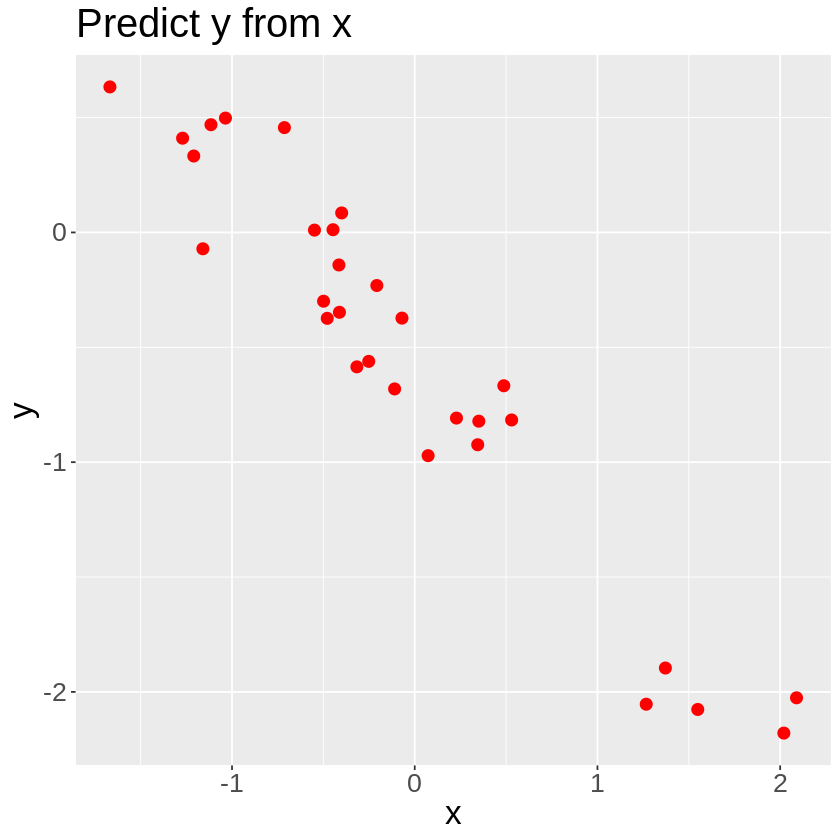

In [5]:
fig1 <- ggplot(df, aes(x=x, y=y)) + 
    geom_point(size=3, color="red") +
    theme(text = element_text(size = 20)) +
    ggtitle('Predict y from x')
fig1 
ggsave(file="fig1.svg", plot=fig1, width=10, height=8)


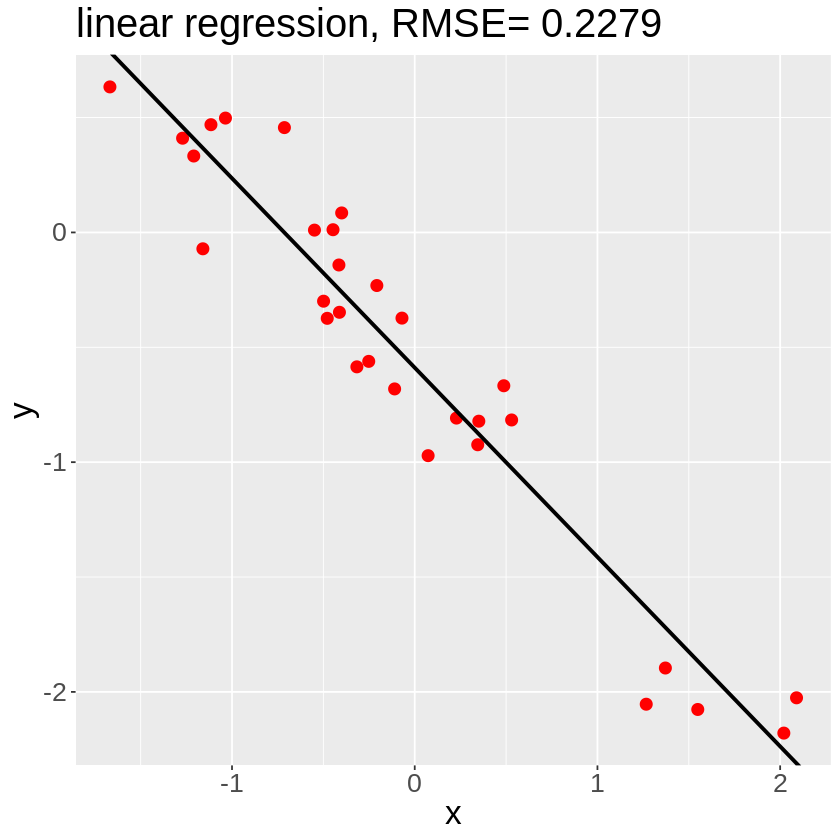

In [6]:
fig2 <- fig1 + geom_abline(intercept = coefficients_full[1], slope = coefficients_full[2],size = 1.1, color="black")  +
    theme(text = element_text(size = 20)) +
    ggtitle(paste('linear regression, RMSE=',format(df_rmse$RMSE_lm,digits=4)))
ggsave(file="fig2.svg", plot=fig2, width=10, height=8)
fig2



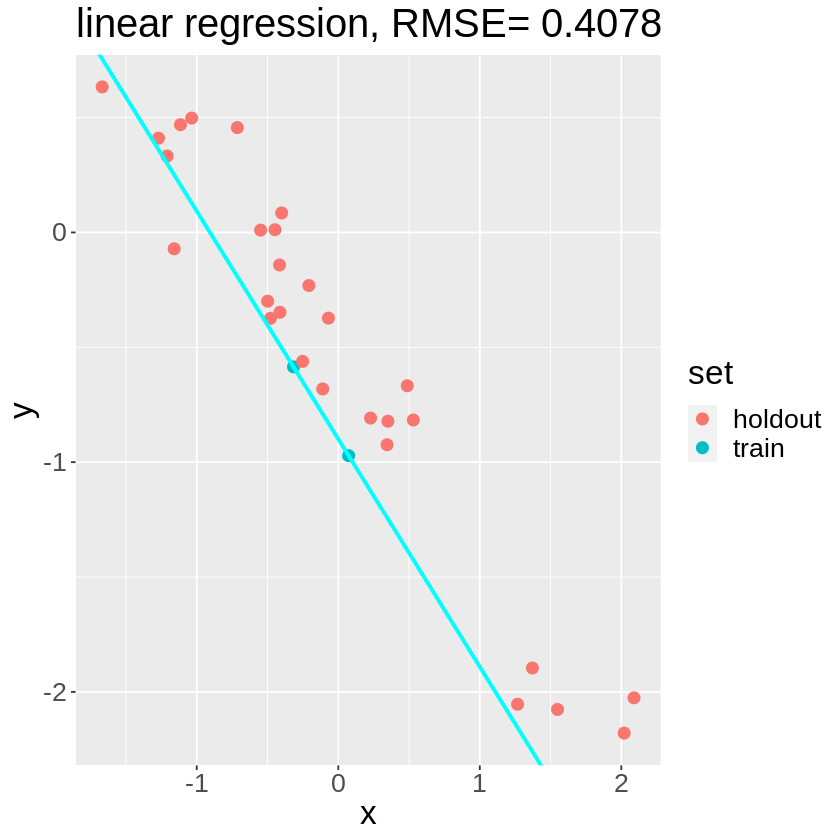

In [7]:
fig3 <- ggplot(df, aes(x=x, y=y,color=set)) + 
        geom_point(size=3) +
        geom_abline(intercept = coefficients[1], slope = coefficients[2], color="cyan1",size = 1.1)  +
        theme(text = element_text(size = 20)) +
        ggtitle(paste('linear regression, RMSE=',format(df_rmse$RMSE_lm_partial,digits=4)))

ggsave(file="fig3.svg", plot=fig3, width=10, height=8)
fig3

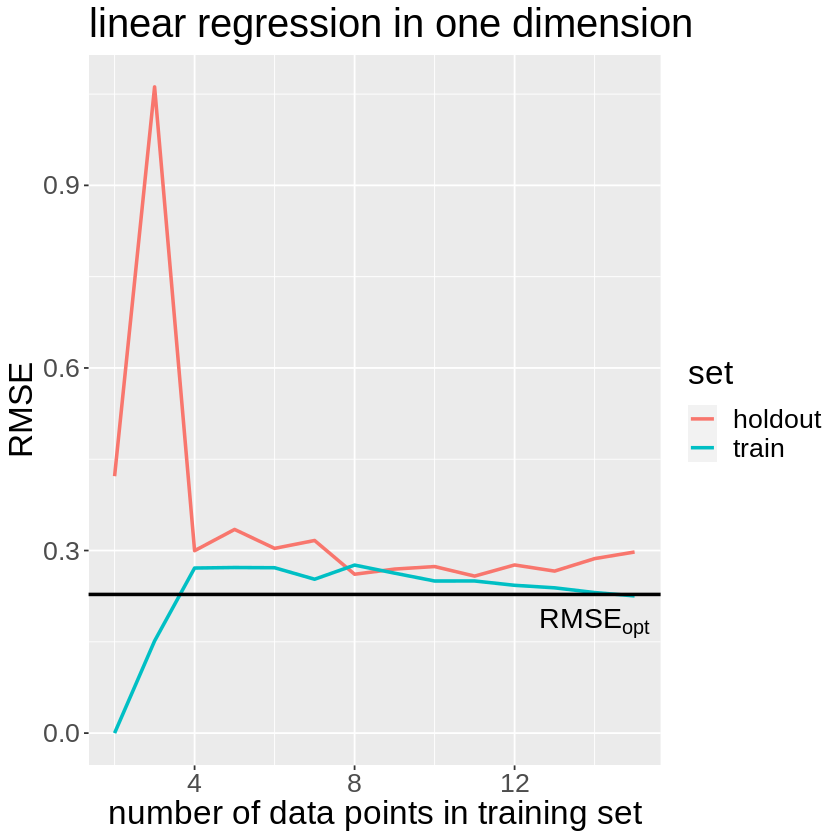

In [8]:
df_summary <- compute_summary(data)
fig4 <- df_summary %>% filter(method == 'linear regression') %>%
ggplot() +
  geom_line(aes(x=m, y=RMSE,color=set),size = 1) +
  geom_hline(yintercept =df_rmse$RMSE_lm,size = 1)+ 
  theme(text = element_text(size = 20)) +
  ggtitle(paste('linear regression in one dimension')) +
  labs(x = "number of data points in training set") + 
  annotate(geom="text", x=14, y=0.18, label="RMSE[opt]",color="black", parse=TRUE,size=6)

ggsave(file="fig4.svg", plot=fig4, width=10, height=8)
fig4

[1] "0.2841"

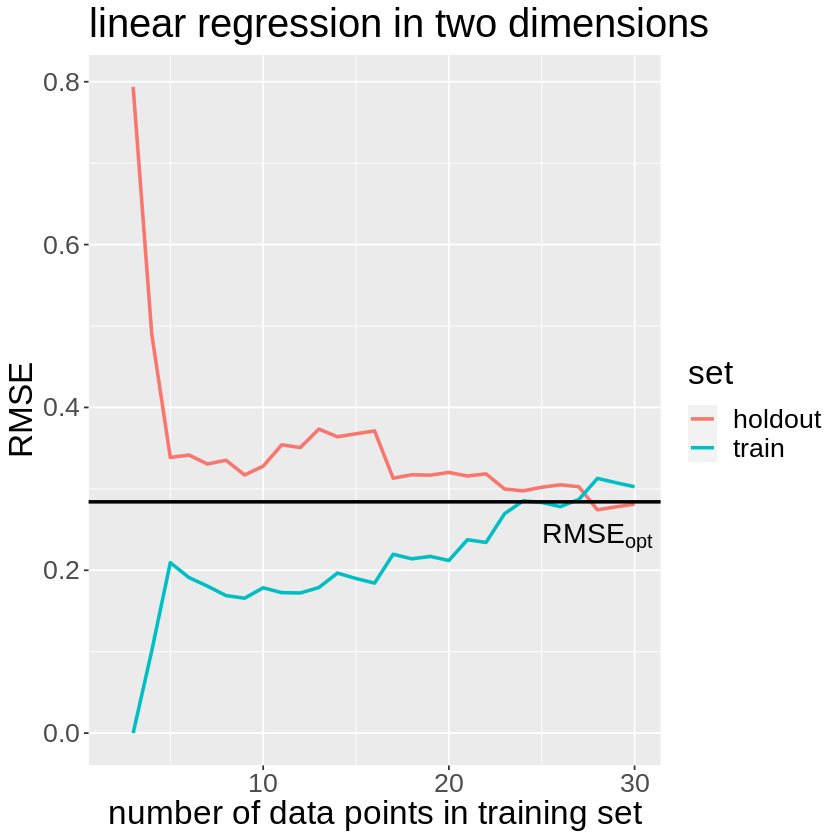

In [9]:
s <- 2
d <- 2
b <- 3
m <- 60
sd <- 0.3
seed <- 133 # 133
data <- generate_data(s,d,m,sd,seed)


df <- data.frame("x"=data[,1],"y"=data[,2],"z"=data[,3])


model <- lm(z ~ x +y ,data = df)
model3 <- lm(z ~ x +y ,data = head(df,b))

df$p_lm <- predict(model, newdata = df) 
df_rmse <- df %>% 
    mutate(residuals_lm = (z-p_lm)*(z-p_lm),count = 1) %>% 
    summarize(RMSE_lm =sqrt(sum(residuals_lm)/sum(count)))


surface <- generate_surface(data,model)

surface3 <- generate_surface(data,model3)

fig5 <- plot_ly(df, 
                     x = ~x, 
                     y = ~y, 
                     z = ~z,
                     type = "scatter3d", 
                     mode = "markers")

#fig <- plot
fig6 <- add_trace(p = fig5,
                       z = surface$z,
                       x = surface$x,
                       y = surface$y,
                       type = "surface",
                       showscale=FALSE,
                       color='Jet')


fig7 <- add_trace(p = fig5,
                       z = surface3$z,
                       x = surface3$x,
                       y = surface3$y,
                       type = "surface",
                       showscale=FALSE,
                       color='Jet')



#embed_notebook(fig5)
#embed_notebook(fig6)
#embed_notebook(fig7)
saveWidget(fig5, "3d.html")
saveWidget(fig6, "lr_3d.html")
saveWidget(fig7, "lr_3d.html")

df_summary <- compute_summary(data)

df_summary <- compute_summary(data)
fig8 <- df_summary %>% filter(method == 'linear regression') %>%
ggplot() +
  geom_line(aes(x=m, y=RMSE,color=set),size = 1) +
  geom_hline(yintercept =df_rmse$RMSE_lm,size=1)+ 
  theme(text = element_text(size = 20)) +
  ggtitle('linear regression in two dimensions') +
  labs(x = "number of data points in training set") +
  annotate(geom="text", x=28, y=0.24, label="RMSE[opt]",color="black", parse=TRUE,size=6)
  
ggsave(file="fig8.svg", plot=fig8, width=10, height=8)
format(df_rmse$RMSE_lm,digits=4)
fig8

In [ ]:
s <- 10
d <- 50
b <- 2
m <- 600
sd <- 0.3
seed <- 133 # 133
data <- generate_data(s,d,m,sd,seed)

df <- data.frame("z"=data[,d+1])
fit_lm <- glmnet(x=data[,1:d], y=data[,d+1], lambda=0,alpha=1)
df$p_lm <- predict(fit_lm,newx=data[,1:d])

df_rmse <- df %>% 
    mutate(residuals_lm = (z-p_lm)*(z-p_lm),count = 1) %>% 
    summarize(RMSE_lm =sqrt(sum(residuals_lm)/sum(count)))

format(df_rmse$RMSE_lm,digits=4)

df_summary <- compute_summary(data)

[1] "0.2868"

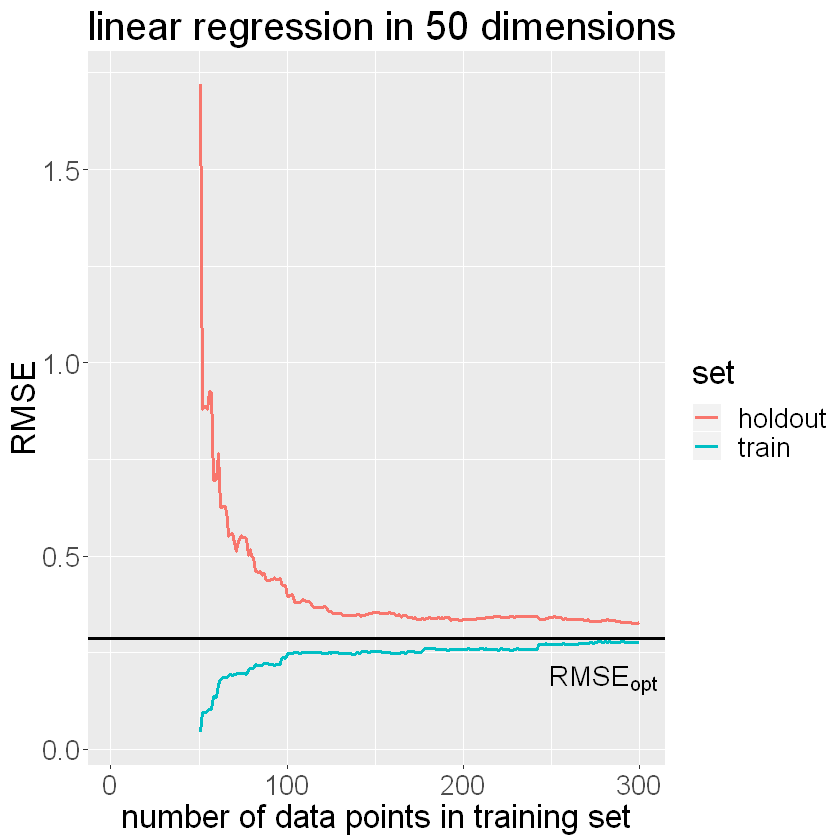

In [ ]:
fig9 <- df_summary %>% filter(method == 'linear regression') %>%
ggplot() +
  geom_line(aes(x=m, y=RMSE,color=set),size = 1)  + 
  geom_hline(yintercept =df_rmse$RMSE_lm,size=1) + 
  theme(text = element_text(size = 20)) +
  #ggtitle(paste('RMSE vs (datapoints in training set), d=50'))
  ggtitle('linear regression in 50 dimensions') +
  labs(x = "number of data points in training set") + 
  annotate(geom="text", x=280, y=0.18, label="RMSE[opt]",color="black", parse=TRUE,size=6) 

ggsave(file="fig9.svg", plot=fig9, width=10, height=8)

fig9

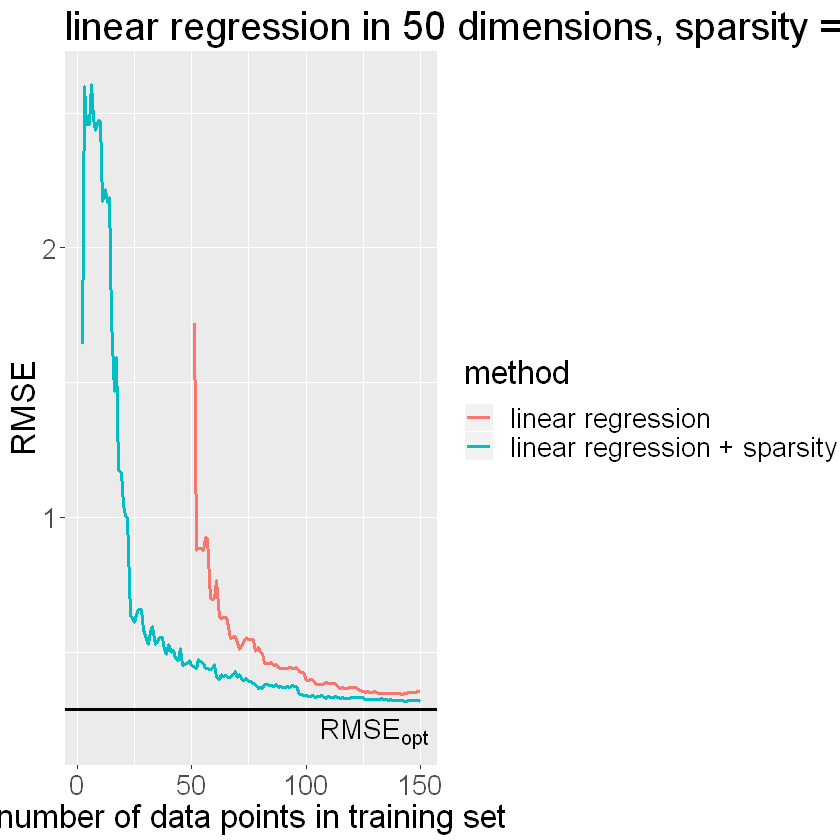

In [ ]:
df_summary_2 <- df_summary  %>% filter(m<=150) %>%
                    mutate(method = if_else(method == 'lasso','linear regression + sparsity','linear regression'))

fig10 <- df_summary_2  %>% filter(set=='holdout') %>%
ggplot() +
  geom_line(aes(x=m, y=RMSE,color=method),size = 1)  + #set,linetype = method
  geom_hline(yintercept =df_rmse$RMSE_lm,size=1) + 
  theme(text = element_text(size = 20)) +
  ggtitle('linear regression in 50 dimensions, sparsity = 10') +
  labs(x = "number of data points in training set") +
  annotate(geom="text", x=130, y=0.2, label="RMSE[opt]",color="black", parse=TRUE,size=6) 

ggsave(file="fig10.svg", plot=fig10, width=12, height=8)
fig10

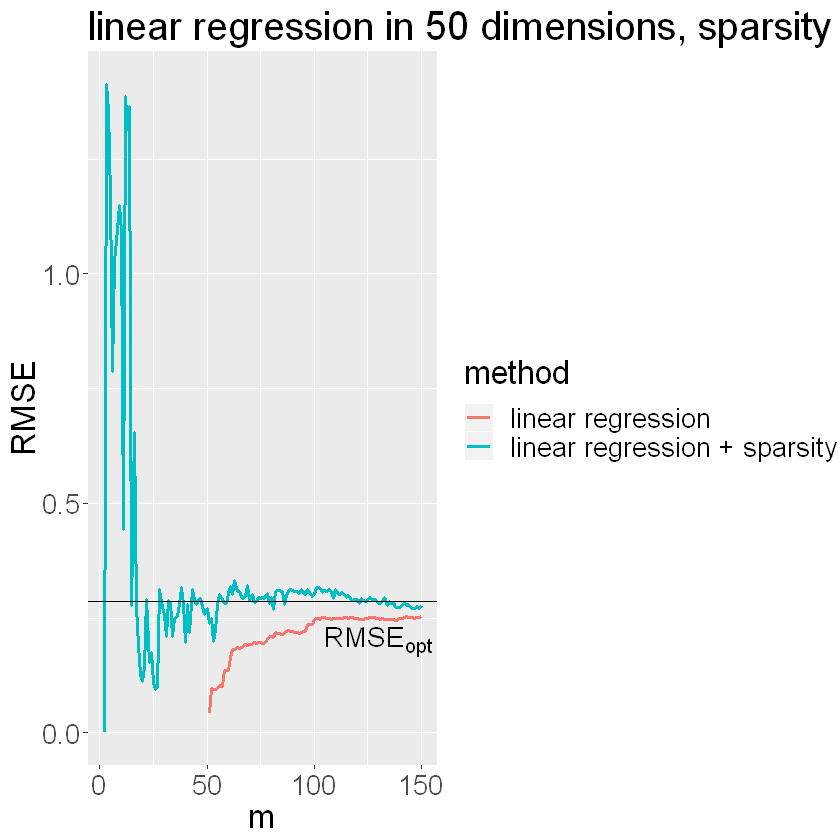

In [ ]:
df_summary_2 <- df_summary  %>% filter(m<=150) %>%
                    mutate(method = if_else(method == 'lasso','linear regression + sparsity','linear regression'))

fig10b <- df_summary_2  %>% filter(set=='train') %>%
ggplot() +
  geom_line(aes(x=m, y=RMSE,color=method),size = 1)  + #set,linetype = method
  geom_hline(yintercept =df_rmse$RMSE_lm) + 
  theme(text = element_text(size = 20)) +
  ggtitle('linear regression in 50 dimensions, sparsity = 10') +
  annotate(geom="text", x=130, y=0.2, label="RMSE[opt]",color="black", parse=TRUE,size=6) 

ggsave(file="fig10b.svg", plot=fig10b, width=12, height=8)
fig10b

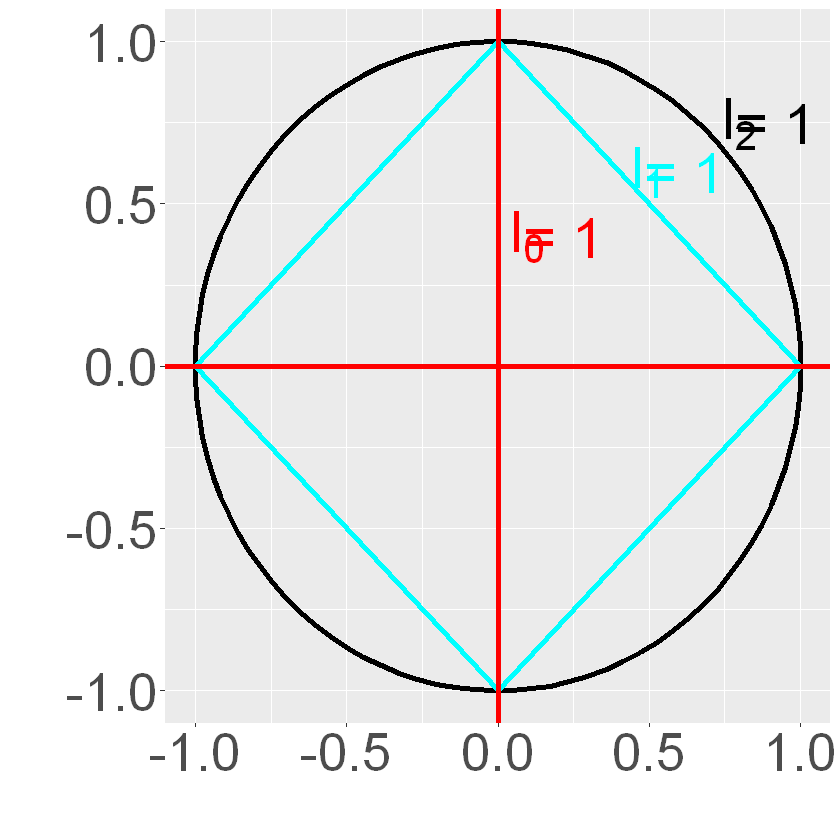

In [ ]:
circleFun <- function(center = c(0,0),r = 1, npoints = 100){
    tt <- seq(0,2*pi,length.out = npoints)
    xx <- center[1] + r * cos(tt)
    yy <- center[2] + r * sin(tt)
    return(data.frame(x = xx, y = yy))
}

diamontFun <- function(center = c(0,0),r = 1, npoints = 100){
    tt <- seq(0,2*pi,length.out = npoints)
    xx <- center[1] + r * cos(tt)
    yy <- center[2] + r * sin(tt)
    return(data.frame(x = xx, y = yy))
}





dat <- circleFun(c(0,0),1,npoints = 100)
#geom_path will do open circles, geom_polygon will do filled circles



r <- 1

x=r*c(-1,0,1,0)
y=r*c(0,1,0,-1)
points <- data.frame("x"=x,"y"=y)
color <- c()
dat <- circleFun(c(0,0),r,npoints = 100)
siz <- 1.5
t_size <- 12

fig11 <- ggplot(dat,aes(x,y)) + geom_path(color='black', size = siz) +
 geom_segment(aes(x = -r, y = 0, xend = 0, yend = r),color='cyan', size = siz) +
 geom_segment(aes(x = 0, y = r, xend = r, yend = 0),color='cyan', size = siz) +
 geom_segment(aes(x = r, y = 0, xend = 0, yend = -r),color='cyan', size = siz) + 
 geom_segment(aes(x = 0, y = -r, xend = -r, yend = 0),color='cyan', size = siz) +
 #geom_point(data=points,aes(x=x,y=y),color='red',size=4) + 
 geom_hline(yintercept = 0, color='red', size = siz) + 
 geom_vline(xintercept = 0, color='red', size = siz) + 
 annotate(geom="text", x=0.8, y=0.75, label="l[2]",color="black", parse=TRUE,size=t_size) + 
 annotate(geom="text", x=0.92, y=0.75, label="= 1",color="black", parse=FALSE,size=t_size) + 
 annotate(geom="text", x=0.5, y=0.6, label="l[1]",color="cyan", parse=TRUE,size=t_size) + 
 annotate(geom="text", x=0.62, y=0.6, label="= 1",color="cyan", parse=FALSE,size=t_size) + 
 annotate(geom="text", x=0.1, y=0.4, label="l[0]",color="red", parse=TRUE,size=t_size) + 
 annotate(geom="text", x=0.22, y=0.4, label="= 1",color="red", parse=FALSE,size=t_size) + 

 labs(x = "", y = "") + 
 theme(text = element_text(size = 40))

ggsave(file="fig11.svg", plot=fig11, width=12, height=12)
fig11



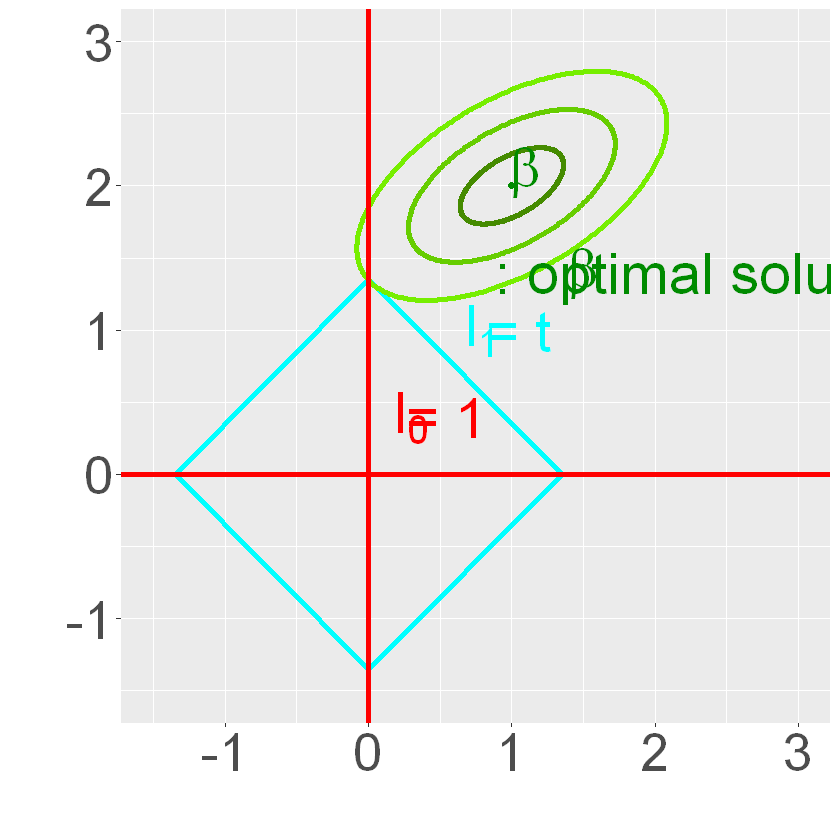

In [ ]:
r <- 1.35
x=r*c(-1,0,1,0)
y=r*c(0,1,0,-1)
points <- data.frame("x"=x,"y"=y)
dat <- circleFun(c(0,0),r,npoints = 100)
beta <- data.frame("x"=c(1),"y"=c(2))
e <- 0.2
rho <- c(0.2,0.4,0.6)


fig12 <- ggplot(dat,aes(x,y)) + #geom_path(color='black',size = siz) +
 geom_segment(aes(x = -r, y = 0, xend = 0, yend = r),color='cyan',size = siz) +
 geom_segment(aes(x = 0, y = r, xend = r, yend = 0),color='cyan',size = siz) +
 geom_segment(aes(x = r, y = 0, xend = 0, yend = -r),color='cyan',size = siz) + 
 geom_segment(aes(x = 0, y = -r, xend = -r, yend = 0),color='cyan',size = siz) +
 geom_ellipse(aes(x0 = 1, y0 = 2, a = rho[1], b = 2*rho[1], angle = -pi / 3),color='chartreuse4',size = siz) +
 geom_ellipse(aes(x0 = 1, y0 = 2, a = rho[2], b = 2*rho[2], angle = -pi / 3),color='chartreuse3',size = siz) +
 geom_ellipse(aes(x0 = 1, y0 = 2, a = rho[3], b = 2*rho[3], angle = -pi / 3),color='chartreuse2',size = siz) +
 #geom_point(data=points,aes(x=x,y=y),color='red',size=4) +
 geom_hline(yintercept = 0, color='red', size = siz) + 
 geom_vline(xintercept = 0, color='red', size = siz) + 
 geom_point(data=beta,aes(x=x,y=y),color="green4",size = siz) + 
 xlim(-1.5,3 )+ylim(-1.5, 3) +  
 annotate(geom="text", x=0.8, y=1, label="l[1]",color="cyan", parse=TRUE,size=t_size) + 
 annotate(geom="text", x=1.05, y=1, label="= t",color="cyan", parse=FALSE,size=t_size) + 
 annotate(geom="text", x=0.3, y=0.4, label="l[0]",color="red", parse=TRUE,size=t_size) + 
 annotate(geom="text", x=0.55, y=0.4, label="= 1",color="red", parse=FALSE,size=t_size) + 
 annotate(geom="text", x=1.1, y=2.1, label="beta",color="green4", parse=TRUE,size=t_size) + 
 annotate(geom="text", x=1.5, y=1.4, label="beta",color="green4", parse=TRUE,size=t_size) + 
 annotate(geom="text", x=2.4, y=1.4, label=": optimal solution",color="green4", parse=FALSE,size=t_size) + 
 labs(x = "", y = "") + 
 theme(text = element_text(size = 40))


ggsave(file="fig12.svg", plot=fig12, width=12, height=12)
fig12

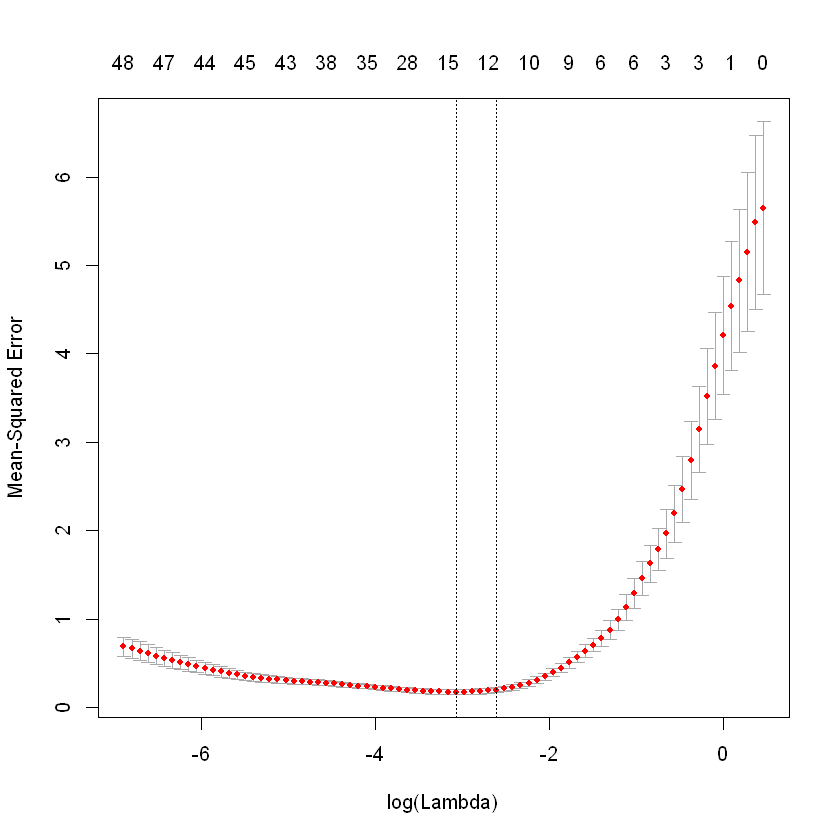

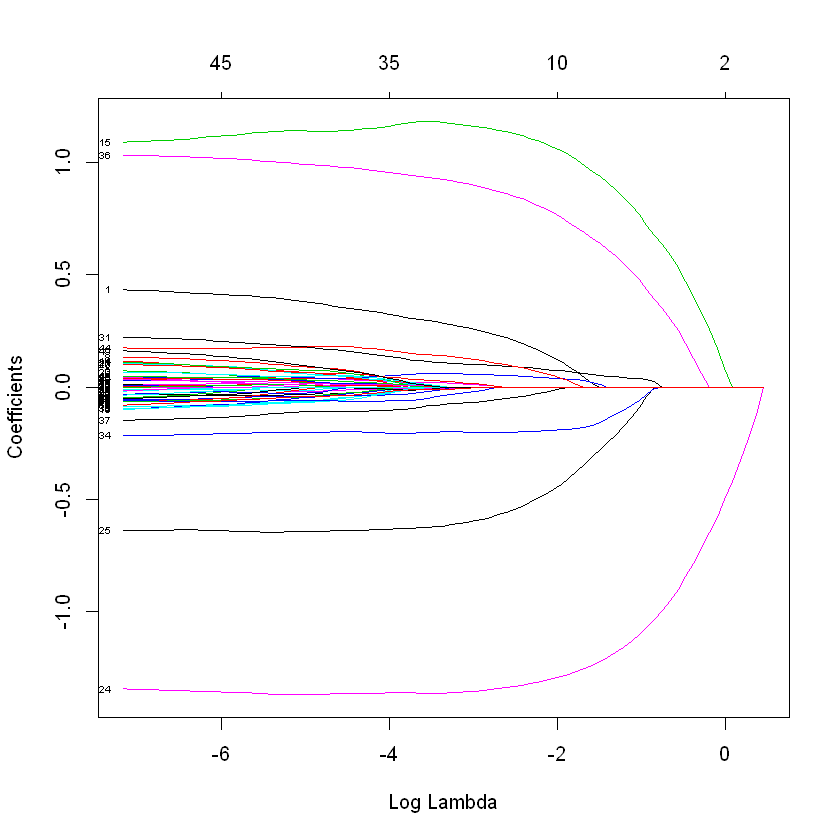

In [ ]:
fit_lasso <- cv.glmnet(x=data[1:60,1:d], y=data[1:60,d+1],alpha=1)
fit_lasso_min <- glmnet(x=data[1:60,1:d], y=data[1:60,d+1], alpha=1)
plot(fit_lasso) 
plot(fit_lasso_min, xvar = "lambda", label = TRUE)


In [ ]:
s <- 1
d <- 2
b <- 3
m <- 80
sd <- 0.5
seed <- 258 # 133
data <- generate_data(s,d,m,sd,seed)


df <- data.frame("x"=data[,1],"y"=data[,2],"z"=data[,3])


fig13 <- plot_ly(df, 
                     x = ~x, 
                     y = ~y, 
                     z = ~z,
                     type = "scatter3d", 
                     mode = "markers")




saveWidget(fig13, "3ds.html")
